### **Imports**

In [1]:
# Environment
from rlkit.envs import UnityEnv

# Algorithms
from rlkit.templates import PPOBasic, PPOTrainConfig, PPOState, ppo_log_keys
from rlkit.modules import PolicyWrapper, ValueWrapper, PPOLossModule
from torch import optim

# Models
import torch
from rlkit.models import MLP

# Utility
import pandas as pd
from dataclasses import asdict
import matplotlib.pyplot as plt
from rlkit.utils import SimpleMetricModule, LoggerBase, TensorBoardLogger

In [2]:
ENV_NAME = '3DBall'

## **Inspect Environment**

In [17]:
env = UnityEnv(ENV_NAME, graphics=True, time_scale=10)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size8', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


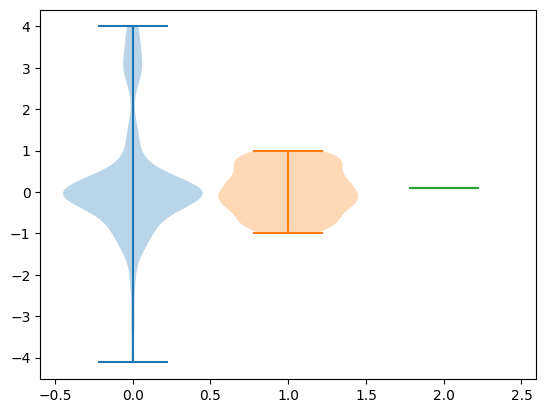

In [18]:
data = env.rollout(10, break_when_any_done=False)

obs_df = pd.DataFrame(data["observation"].reshape(-1))
act_df = pd.DataFrame(data["action"].reshape(-1))
rew_df = pd.DataFrame(data["next", "reward"].reshape(-1))

for i, df in enumerate([obs_df, act_df, rew_df]):
    plt.violinplot(df, positions=[i], widths=0.9)

In [19]:
env.close()
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([12, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([12, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([12, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([12, 10, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([12, 10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([12, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([12, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([12, 10]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([12, 10, 8])

## **PPO**

### **Env Config**

In [3]:
env = UnityEnv(ENV_NAME, graphics=False)
env_batch_dim = env.batch_dims
obs_dim = env.observation_spec["observation"].shape[env_batch_dim]
action_dim = env.action_spec.shape[env_batch_dim]
env.close()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size8', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


### **Config**

In [9]:
# PPO
ppo_algo_config = {
    "epsilon": 0.2,
    "entropy_coef": 1e-3,
    "gamma": 0.99,
    "lmbda": 0.95,
}

# Model
model_config = {
    "in_features": obs_dim,
    "out_features": action_dim,
    "n_blocks": 1,
    "hidden_dim": 32,
}

# Training
config = PPOTrainConfig(
    generations=100,
    generation_size=10_000,
    slice_len=128,
    n_slices=256,
    epochs=2,
    minibatch_size=256,

    workers=8,
    env_batch_dim=env_batch_dim,

    kl_soft_clip=0.02,
    early_stop_threshold=32,
    kl_hard_clip=0.05,

    start_generation=0,
)
LR = 1e-4

model_config

{'in_features': 8, 'out_features': 2, 'n_blocks': 1, 'hidden_dim': 32}

### **State**

In [11]:
action_type = 'continuous'

# Policy
policy_config = model_config.copy()
policy_config["out_features"] *= 2
policy_base = MLP(**policy_config)
policy = PolicyWrapper(policy_base, policy_type=action_type)

# Value
value_config = model_config.copy()
value_config["out_features"] = 1
value_base = MLP(**value_config)
value = ValueWrapper(value_base)

# Loss Module
loss_module = PPOLossModule(policy, value, **ppo_algo_config)

# Optimizer
optimizer = optim.Adam(loss_module.parameters(), lr=LR)

# Logger
logger = TensorBoardLogger(ppo_log_keys, log_dir='temp/logs') # LoggerBase(ppo_log_keys)
logger.reset()

# State
state = PPOState(
    policy=policy,
    value=value,
    optimizer=optimizer,
    loss_module=loss_module,

    logger=logger,
)

### **PPO**

In [12]:
ppo = PPOBasic(lambda: UnityEnv(ENV_NAME, graphics=False), ppo_config=config, ppo_state=state)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [13]:
ppo.run(verbose=True)

[1/100] Starting Generation
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 6)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 6)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 7)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 11)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 11)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 11)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 13)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 13)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age = 13)
Internal: deleting an allocation that is older than its permitted lifetime of 4 frames (age =

### **Plot Results**

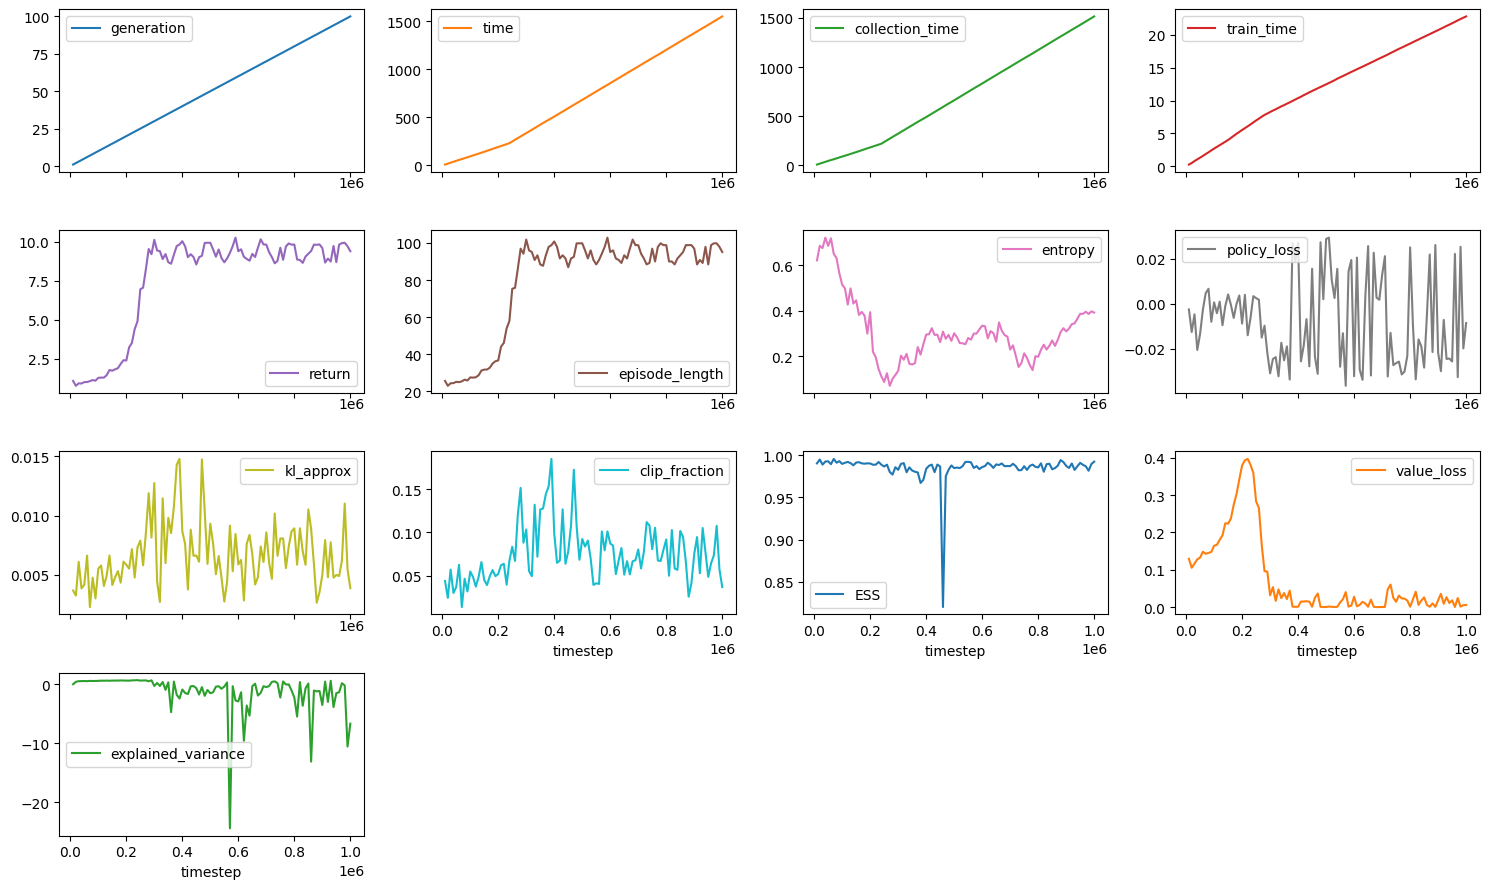

In [14]:
LOG_INDEX = "timestep"
def plot():
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)

    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.show()
plot()

## **Evaluate Agent**

In [15]:
try: env.close()
except: pass

env = UnityEnv(ENV_NAME, graphics=True)
env.reset()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size8', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Setting up 7 worker threads for Enlighten.
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 92.1 KB
      Overflow Count 8
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
   

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([12]),
    device=cpu,
    is_shared=False)

In [16]:
data = None
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

KeyboardInterrupt: 

In [16]:
try: env.close()
except: pass

SimpleMetricModule(mode="approx")(data)

{'return': 3.9197118282318115,
 'episode_length': 57.69230651855469,
 'entropy': 0.20180444419384003}